In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Bidirectional
from keras.utils.np_utils import to_categorical
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score
import joblib

import time
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [2]:
def StringToBytes(data):
    sum = 0
    arrbytes = bytes(data, 'utf-8')
    for i in arrbytes:
        sum = sum + i
    return(sum)

In [3]:
data_normal_1 = pd.read_csv('dataset/timeseries/tcp_dataset_timeseries_normal_1.csv')
data_normal_2 = pd.read_csv('dataset/timeseries/tcp_dataset_timeseries_normal_2.csv')
data_normal_3 = pd.read_csv('dataset/timeseries/tcp_dataset_timeseries_normal_3.csv')
data_normal_4 = pd.read_csv('dataset/timeseries/tcp_dataset_timeseries_normal_4.csv')

data_normal_5 = pd.read_csv('dataset/timeseries/old/dataset_tcp_timeseries_normal_3.csv')

data_attack_1 = pd.read_csv('dataset/timeseries/tcp_dataset_timeseries_attack_1.csv')
data_attack_2 = pd.read_csv('dataset/timeseries/tcp_dataset_timeseries_attack_2.csv')
data_attack_3 = pd.read_csv('dataset/timeseries/tcp_dataset_timeseries_attack_3.csv')

data_attack_4 = pd.read_csv('dataset/timeseries/old/dataset_tcp_timeseries_attack_1.csv')

In [4]:
data_normal_1.columns = ['port_src', 'seq', 'ack', 'dataofs', 'reserved', 'flags',
       'window', 'chksum', 'urgptr', 'payload_len', 'label']
data_normal_2.columns = ['port_src', 'seq', 'ack', 'dataofs', 'reserved', 'flags',
       'window', 'chksum', 'urgptr', 'payload_len', 'label']
data_normal_3.columns = ['port_src', 'seq', 'ack', 'dataofs', 'reserved', 'flags',
       'window', 'chksum', 'urgptr', 'payload_len', 'label']
data_normal_4.columns = ['port_src', 'seq', 'ack', 'dataofs', 'reserved', 'flags',
       'window', 'chksum', 'urgptr', 'payload_len', 'label']

data_normal_5.columns = ['timestamp', 'port_src', 'port_dest',
       'seq', 'ack', 'dataofs', 'reserved', 'flags',
       'window', 'chksum', 'urgptr', 'payload_len', 'label']

data_attack_1.columns = ['port_src', 'seq', 'ack', 'dataofs', 'reserved', 'flags',
       'window', 'chksum', 'urgptr', 'payload_len', 'label']
data_attack_2.columns = ['port_src', 'seq', 'ack', 'dataofs', 'reserved', 'flags',
       'window', 'chksum', 'urgptr', 'payload_len', 'label']
data_attack_3.columns = ['port_src', 'seq', 'ack', 'dataofs', 'reserved', 'flags',
       'window', 'chksum', 'urgptr', 'payload_len', 'label']

data_attack_4.columns = ['timestamp', 'port_src', 'port_dest',
       'seq', 'ack', 'dataofs', 'reserved', 'flags',
       'window', 'chksum', 'urgptr', 'payload_len', 'label']

In [5]:
data_normal_5 = data_normal_5.drop(['timestamp', 'port_dest'],axis=1)

data_attack_4 = data_attack_4.drop(['timestamp', 'port_dest'],axis=1)

In [6]:
features = ['port_src', 'seq', 'ack', 'dataofs', 'reserved', 'flags',
       'window', 'chksum', 'urgptr', 'payload_len']

In [7]:
X_normal_1 = data_normal_1[features].values
X_normal_2 = data_normal_2[features].values
X_normal_3 = data_normal_3[features].values
X_normal_4 = data_normal_4[features].values
X_normal_5 = data_normal_5[features].values

X_attack_1 = data_attack_1[features].values
X_attack_2 = data_attack_2[features].values
X_attack_3 = data_attack_3[features].values
X_attack_4 = data_attack_4[features].values

Y_normal_1 = data_normal_1['label']
Y_normal_2 = data_normal_2['label']
Y_normal_3 = data_normal_3['label']
Y_normal_4 = data_normal_4['label']
Y_normal_5 = data_normal_5['label']

Y_attack_1 = data_attack_1['label']
Y_attack_2 = data_attack_2['label']
Y_attack_3 = data_attack_3['label']
Y_attack_4 = data_attack_4['label']

X=np.concatenate((X_normal_1,X_normal_2,X_normal_3,X_normal_4,X_normal_5,X_attack_1,X_attack_2,X_attack_3,X_attack_4))
Y=np.concatenate((Y_normal_1,Y_normal_2,Y_normal_3,Y_normal_4,Y_normal_5,Y_attack_1,Y_attack_2,Y_attack_3,Y_attack_4))

In [8]:
for i in range(len(X)):
    X[i][5] = StringToBytes(str(X[i][5]))

In [9]:
scalar = StandardScaler(copy=True, with_mean=True, with_std=True)
scalar.fit(X)
X = scalar.transform(X)

In [10]:
print(np.shape(X))
print(np.shape(Y))

(186785, 10)
(186785,)


In [11]:
features = len(X[0])
samples = X.shape[0]
train_len = 200
input_len = samples - train_len
I = np.zeros((samples - train_len, train_len, features))

In [12]:
for i in range(input_len):
    temp = np.zeros((train_len, features))
    for j in range(i, i + train_len - 1):
        temp[j-i] = X[j]
    I[i] = temp

In [13]:
print(I.shape)

(186585, 200, 10)


In [14]:
X_train, X_test, Y_train, Y_test = train_test_split(I, Y[200:], test_size = 0.2, stratify=Y[200:], random_state = 0)

In [15]:
def create_baseline():
    model = Sequential()
    model.add(Bidirectional(LSTM(64, activation='tanh', kernel_regularizer='l2')))
    model.add(Dense(128, activation = 'relu', kernel_regularizer='l2'))
    model.add(Dense(1, activation = 'sigmoid', kernel_regularizer='l2'))
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    return model

In [16]:
model = create_baseline()

In [17]:
checkpoint = ModelCheckpoint("LSTMmodel.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')

In [18]:
history = model.fit(X_train, Y_train, epochs = 30,validation_split=0.2, verbose = 1, callbacks=[checkpoint,early])

Epoch 1/30
3732/3732 [==============================] - ETA: 0s - loss: 0.0889 - accuracy: 0.9912
Epoch 00001: val_loss improved from inf to 0.02683, saving model to LSTMmodel.h5
3732/3732 [==============================] - 113s 29ms/step - loss: 0.0889 - accuracy: 0.9912 - val_loss: 0.0268 - val_accuracy: 0.9999
Epoch 2/30
3732/3732 [==============================] - ETA: 0s - loss: 0.0538 - accuracy: 0.9934
Epoch 00002: val_loss did not improve from 0.02683
3732/3732 [==============================] - 109s 29ms/step - loss: 0.0538 - accuracy: 0.9934 - val_loss: 0.0819 - val_accuracy: 0.9864
Epoch 3/30
3731/3732 [============================>.] - ETA: 0s - loss: 0.0588 - accuracy: 0.9920
Epoch 00003: val_loss did not improve from 0.02683
3732/3732 [==============================] - 120s 32ms/step - loss: 0.0588 - accuracy: 0.9920 - val_loss: 0.0424 - val_accuracy: 0.9965
Epoch 4/30
3731/3732 [============================>.] - ETA: 0s - loss: 0.0526 - accuracy: 0.9935
Epoch 00004: val_

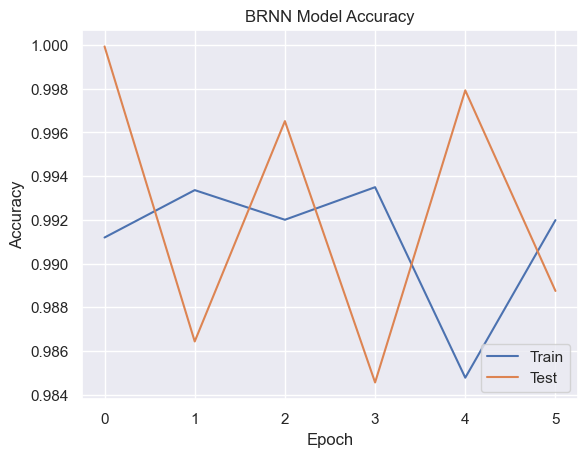

In [19]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('BRNN Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.savefig('BRNN 200 Model Accuracy.png')
plt.show()

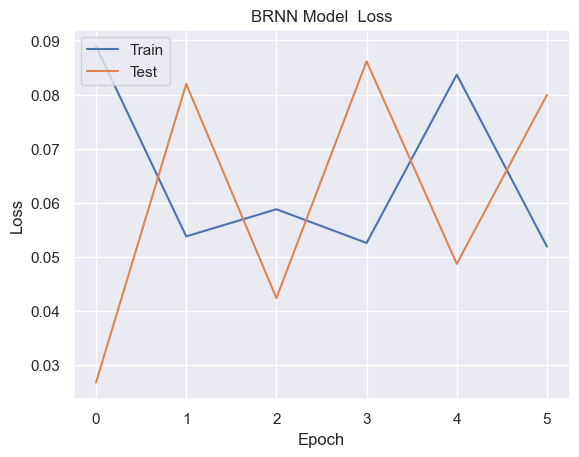

In [20]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('BRNN Model  Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('BRNN 200 Model Loss.png')
plt.show()

In [21]:
predict = model.predict(X_test, verbose=1)

1167/1167 [==============================] - 17s 14ms/step


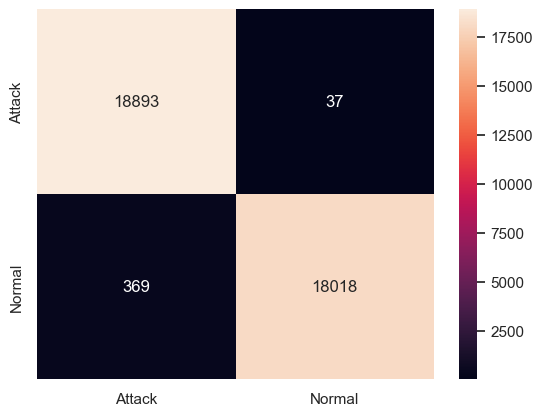

In [22]:
tp = 0
tn = 0
fp = 0
fn = 0
predictn = predict.flatten().round()
predictn = predictn.tolist()
Y_testn = Y_test.tolist()
for i in range(len(Y_testn)):
  if predictn[i]==1 and Y_testn[i]==1:
    tp+=1
  elif predictn[i]==0 and Y_testn[i]==0:
    tn+=1
  elif predictn[i]==0 and Y_testn[i]==1:
    fp+=1
  elif predictn[i]==1 and Y_testn[i]==0:
    fn+=1
to_heat_map =[[tn,fp],[fn,tp]]
to_heat_map = pd.DataFrame(to_heat_map, index = ["Attack","Normal"],columns = ["Attack","Normal"])
ax = sns.heatmap(to_heat_map,annot=True, fmt="d")

In [23]:
figure = ax.get_figure()
figure.savefig('confusion_matrix_BRNN_200.png', dpi=400)

In [24]:
# model.save('brnn_model_200_step.h5')
joblib.dump(scalar, 'scaler_200.save')

['scaler_200.save']

In [25]:
scores = model.evaluate(X_test, Y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

accuracy: 98.91%


In [26]:
print(classification_report(Y_testn,predictn))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     19262
           1       0.98      1.00      0.99     18055

    accuracy                           0.99     37317
   macro avg       0.99      0.99      0.99     37317
weighted avg       0.99      0.99      0.99     37317



In [27]:
lr_auc = roc_auc_score(Y_testn, predictn)
print('SVM: ROC AUC=%.3f' % (lr_auc))

SVM: ROC AUC=0.989


In [28]:
time_start = time.perf_counter()
predict = model.predict(I[:200], verbose=1)
print(f"Time elapse for prediction : {time.perf_counter() - time_start}")
print(predict)

7/7 [==============================] - 0s 13ms/step
Time elapse for prediction : 0.13373219999994035
[[0.00029933]
 [0.0002986 ]
 [0.00029902]
 [0.00029863]
 [0.00029843]
 [0.00029836]
 [0.0002942 ]
 [0.000296  ]
 [0.00029397]
 [0.00029609]
 [0.00029643]
 [0.00029786]
 [0.00029623]
 [0.00029876]
 [0.00029707]
 [0.00029697]
 [0.00029682]
 [0.00029652]
 [0.00029618]
 [0.00029483]
 [0.06078424]
 [0.00029384]
 [0.00029393]
 [0.00029393]
 [0.00029358]
 [0.00029354]
 [0.00029349]
 [0.00029337]
 [0.00029324]
 [0.00029279]
 [0.00029183]
 [0.00029194]
 [0.00029206]
 [0.00029227]
 [0.00029263]
 [0.00029299]
 [0.00029442]
 [0.0002978 ]
 [0.00029584]
 [0.00029461]
 [0.00029344]
 [0.00029522]
 [0.00029618]
 [0.00029459]
 [0.06161997]
 [0.06183744]
 [0.06225306]
 [0.06180534]
 [0.06217035]
 [0.06122982]
 [0.06116366]
 [0.06122012]
 [0.06124369]
 [0.06134716]
 [0.06144928]
 [0.00029405]
 [0.00029423]
 [0.00029483]
 [0.00029655]
 [0.00029647]
 [0.00029582]
 [0.00029706]
 [0.00029436]
 [0.00029446]
 [0